In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/yermaand/audio-nn'

In [3]:
from glob import glob
import os
import shutil
import subprocess
from src import *
import matplotlib.pyplot as plt
import scipy.signal as S

In [17]:
def plot_alignment(signals, ax=plt, sr=44100, each=100, from_time=0, till_time=60*3):
    from_sample = int(sr * from_time)
    till_sample = int(sr * till_time)
    if ax == plt:
        ax.figure(figsize=(20, 10))
    for signal in signals:
        ax.plot(signal[from_sample:till_sample:each], alpha=0.5)

In [5]:
def align_signals(reference, target, sr=44100):
    corr = S.correlate(reference, target)
    lags = S.correlation_lags(len(reference), len(target))
    lag = lags[corr.argmax()]
    print(f'lag {lag / sr:.2f} [s]')
    
    if lag > 0:
        return torch.cat([torch.zeros(lag), target[:-lag]])
    else:
        lag = abs(lag)
        # return torch.cat([target[lag:], torch.zeros(lag)])
        return target[lag:]

# Part I

In [6]:
files = load_files_from_dataset('002_eyedea_RX100')
files_all = load_files_from_dataset('000_eyedea_all')

In [7]:
alignmnemt_dict = {k: [] for k in files}

files = sorted(glob('data/audio/*'))
for k, v in alignmnemt_dict.items():
    for file_path in files_all:
        file_name = file_path.split('/')[-1].split('.')[0]
        if file_name[:2] == k[:2] and file_name != k and file_name not in alignmnemt_dict[k]:
            alignmnemt_dict[k].append(file_name)
    print(k, v)

05_RX100 ['05_Mobius', '05_iphone']
06_RX100 ['06_Mobius']
07_RX100 []
09_RX100 ['09_Mobius', '09_iphone']
10_RX100 ['10_Mobius', '10_iphone']
11_RX100 ['11_Mobius', '11_iphone']
12_RX100 ['12_Mobius', '12_iphone']
13_RX100 ['13_Mobius', '13_iphone']
14_RX100 ['14_Mobius']
15_RX100 ['15_Mobius', '15_iphone']
16_RX100 ['16_Mobius', '16_iphone']
17_RX100 ['17_Mobius', '17_iphone']
18_Prazska_RX100 ['18_Prazska_Mobius', '18_Prazska_iphone']
19_Krocehlavska_RX100 ['19_Krocehlavska_Mobius', '19_Krocehlavska_iphone']
20_Kovary_RX100 ['20_Kovary_Mobius', '20_Kovary_iphone']
21_Videnska_RX100 ['21_Videnska_Mobius', '21_Videnska_iphone']
22_Jesenicka_RX100 ['22_Jesenicka_Mobius', '22_Jesenicka_iphone']
23_KeZlatnikum_RX100 ['23_KeZlatnikum_Mobius', '23_KeZlatnikum_iphone']
24_Cernokostelecka_RX100 ['24_Cernokostelecka_Mobius', '24_Cernokostelecka_iphone']
25_Hlavni_RX100 ['25_Hlavni_Mobius', '25_Hlavni_iphone']
26_Novosibrinska_RX100 ['26_Novosibrinska_Mobius', '26_Novosibrinska_iphone']
27_Kom

### Example

lag -1.28 [s]
lag -2.17 [s]


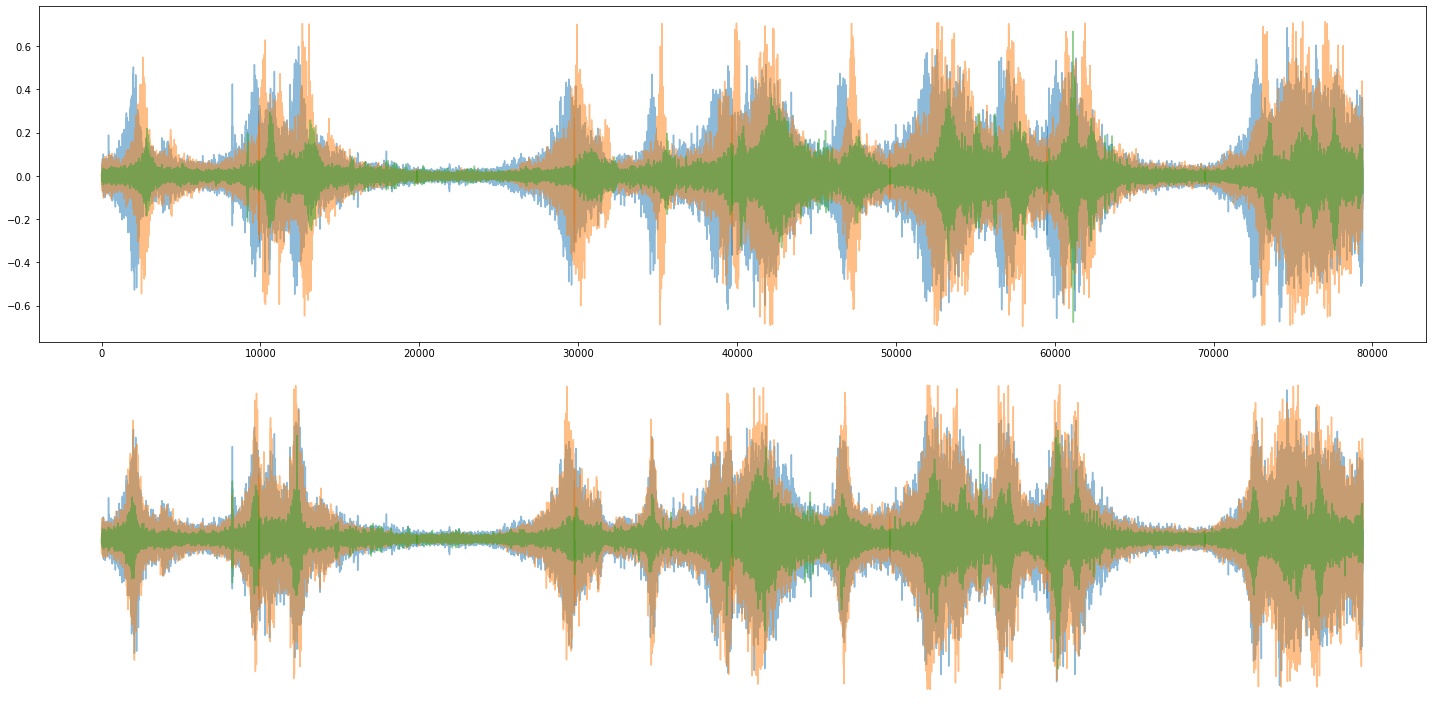

In [10]:
# example
# load wav files
signal_1, sr = load_audio('32_Cementarska_RX100', return_sr=True)
signal_2 = load_audio('32_Cementarska_Mobius')
signal_3 = load_audio('32_Cementarska_iphone')

# align 
signal_2_aligned = align_signals(signal_1, signal_2)
signal_3_aligned = align_signals(signal_1, signal_3)

# show
fig, axes = plt.subplots(2, figsize=(20, 10))
plot_alignment([signal_1, signal_2, signal_3], ax=axes[0])
plot_alignment([signal_1, signal_2_aligned, signal_3_aligned], ax=axes[1])
plt.tight_layout() 

# save
# torch.save([signal_1, sr], 'data/audio_tensors/12_RX100.MP4.pt')
# torch.save([signal_2_aligned, sr], 'data/audio_tensors/12_iphone.MP4.pt')
# torch.save([signal_3_aligned, sr], 'data/audio_tensors/12_Mobius.MP4.pt')

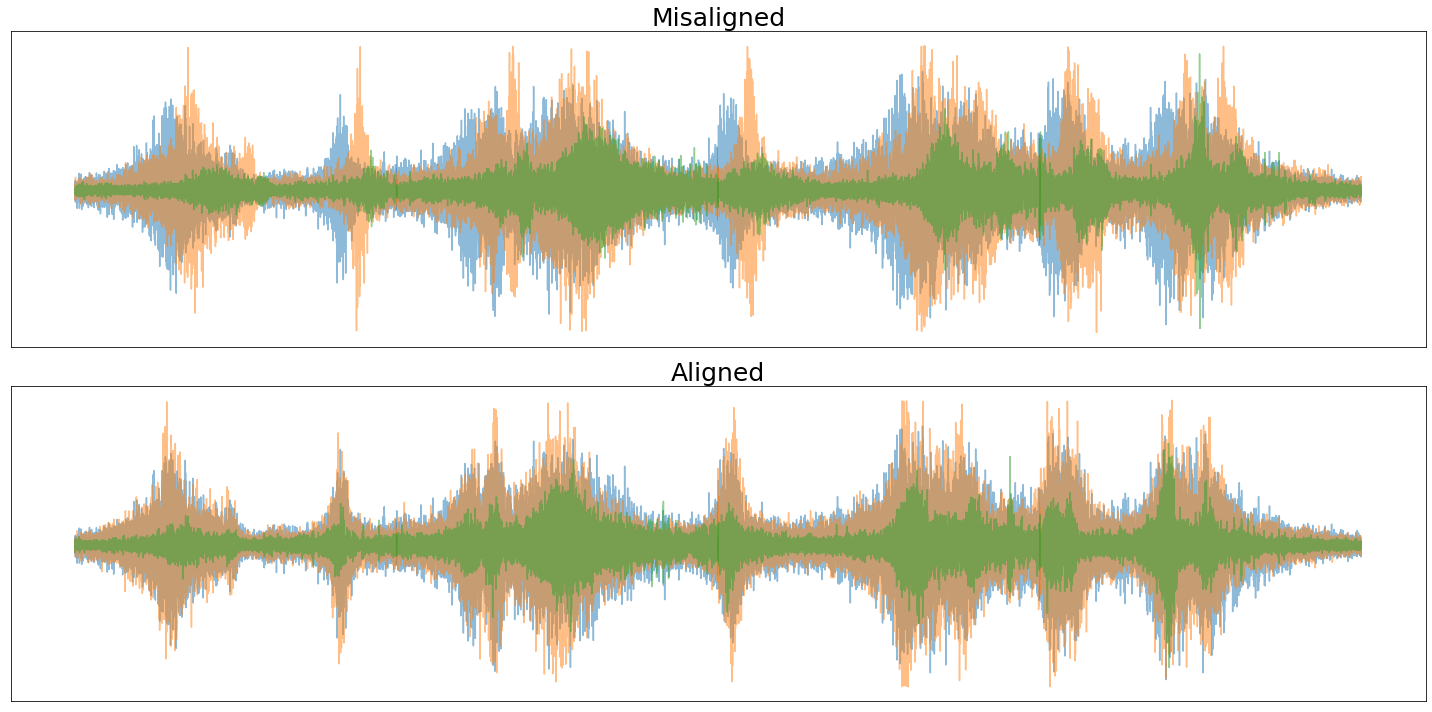

In [20]:
fig, axes = plt.subplots(2, figsize=(20, 10))

from_time = 60
till_time = 60 * 2 + 30
plot_alignment([signal_1, signal_2, signal_3], from_time=from_time, till_time=till_time, ax=axes[0])
plot_alignment([signal_1, signal_2_aligned, signal_3_aligned], from_time=from_time, till_time=till_time, ax=axes[1])
for ax in axes:
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
axes[0].set_title('Misaligned', fontsize=25)
axes[1].set_title('Aligned', fontsize=25)
plt.tight_layout()
plt.savefig('plots/aligned_signals.png', dpi=150)

In [11]:
get_signal_length(signal_1, sr), get_signal_length(signal_2, sr), get_signal_length(signal_3, sr)

(1236, 1232, 1235)

### Cycle

In [13]:
subfolder = 'eyedea_aligned'
camera_name = 'RX100'

In [14]:
os.makedirs(f'data/audio_pt/{subfolder}', exist_ok=True)
os.makedirs(f'data/csv/{subfolder}', exist_ok=True)

for reference_name, targets in alignmnemt_dict.items():
    print(f'\n{reference_name}')

    # load reference signal
    reference_signal, sr = load_audio(reference_name, return_sr=True)
    
    signals = [reference_signal]
    signals_aligned = [reference_signal]
    for target_name in targets:
        # load target signal
        target_signal = load_audio_wav(f'data/audio_wav/{target_name}.wav')
        signals.append(target_signal)

        # align reference and target signals
        aligned_signal = align_signals(reference_signal, target_signal)
        signals_aligned.append(aligned_signal)

        print(f'{target_name}: {get_signal_length(aligned_signal, sr)} [s]')

        # save aligned target signal
        audio_pt = f'data/audio_pt/{subfolder}/{target_name}_aligned_{camera_name}.pt'
        if not os.path.exists(audio_pt):
            torch.save([aligned_signal, sr], audio_pt)
        
        # save csv
        csv_reference = find_csv(reference_name)
        csv_target = f'data/csv/{subfolder}/{target_name}_aligned_{camera_name}.csv'
        if not os.path.exists(csv_target):
            shutil.copy2(csv_reference, csv_target)

    plt_path = f'plots/alignments/{reference_name}.png'
    if not os.path.exists(plt_path):
        fig, axes = plt.subplots(2, figsize=(20, 10))
        plot_alignment(signals, ax=axes[0])
        plot_alignment(signals_aligned, ax=axes[1])
        plt.tight_layout()
        plt.savefig(plt_path)



05_RX100
lag 0.19 [s]
05_Mobius: 1170 [s]
lag -1.99 [s]
05_iphone: 1169 [s]

06_RX100
lag 0.47 [s]
06_Mobius: 1389 [s]

07_RX100

09_RX100
lag -0.09 [s]
09_Mobius: 1257 [s]
lag -2.02 [s]
09_iphone: 1261 [s]

10_RX100
lag 0.11 [s]
10_Mobius: 1180 [s]
lag 0.43 [s]
10_iphone: 1174 [s]

11_RX100
lag -0.31 [s]
11_Mobius: 1285 [s]
lag 1.93 [s]
11_iphone: 1284 [s]

12_RX100
lag 0.69 [s]
12_Mobius: 1235 [s]
lag 1.83 [s]
12_iphone: 1232 [s]

13_RX100
lag 0.70 [s]
13_Mobius: 1264 [s]
lag -1.29 [s]
13_iphone: 1265 [s]

14_RX100
lag -1.25 [s]
14_Mobius: 1371 [s]

15_RX100
lag 0.18 [s]
15_Mobius: 1203 [s]
lag 1.18 [s]
15_iphone: 1198 [s]

16_RX100
lag -0.46 [s]
16_Mobius: 1216 [s]
lag -0.74 [s]
16_iphone: 1212 [s]

17_RX100
lag 4.87 [s]
17_Mobius: 1237 [s]
lag 0.66 [s]
17_iphone: 1242 [s]

18_Prazska_RX100
lag -1.54 [s]
18_Prazska_Mobius: 1226 [s]
lag 8.76 [s]
18_Prazska_iphone: 739 [s]

19_Krocehlavska_RX100
lag -0.79 [s]
19_Krocehlavska_Mobius: 1229 [s]
lag -1.53 [s]
19_Krocehlavska_iphone: 1229

In [8]:
from preprocess_data import preprocess

files_to_preprocess = []
for v in alignmnemt_dict.values():
    files_to_preprocess.extend(v)
files_to_preprocess = [f'{name}_aligned' for name in files_to_preprocess]
preprocess(files_to_preprocess)

files_to_preprocess = list(alignmnemt_dict.keys())
preprocess(files_to_preprocess)

--------------------------------------------------
File:  01_Vypadova_A41

Extracting audio
file data/audio_tensors/01_Vypadova_A41.MP4.pt exists

Extracting labels
01_Vypadova_A41: 0.95, 0.55

Extracting intervals
data/labels/01_Vypadova_A41.MP4.txt 9
--------------------------------------------------
File:  03_KPrehradam_A6000

Extracting audio
file data/audio_tensors/03_KPrehradam_A6000.MP4.pt exists

Extracting labels
03_KPrehradam_A6000: 2.15, 0.45

Extracting intervals
data/labels/03_KPrehradam_A6000.MP4.txt 23
--------------------------------------------------
File:  05_RX100

Extracting audio
file data/audio_tensors/05_RX100.MP4.pt exists

Extracting labels
05_RX100: 1.35, 1.15

Extracting intervals
data/labels/05_RX100.MP4.txt 32
--------------------------------------------------
File:  06_RX100

Extracting audio
file data/audio_tensors/06_RX100.MP4.pt exists

Extracting labels
06_RX100: 1.55, 0.85

Extracting intervals
data/labels/06_RX100.MP4.txt 34
-------------------------

# Part II

In [ ]:
config = Config()
config.normalization = 'global'
transformation = create_transformation(config)

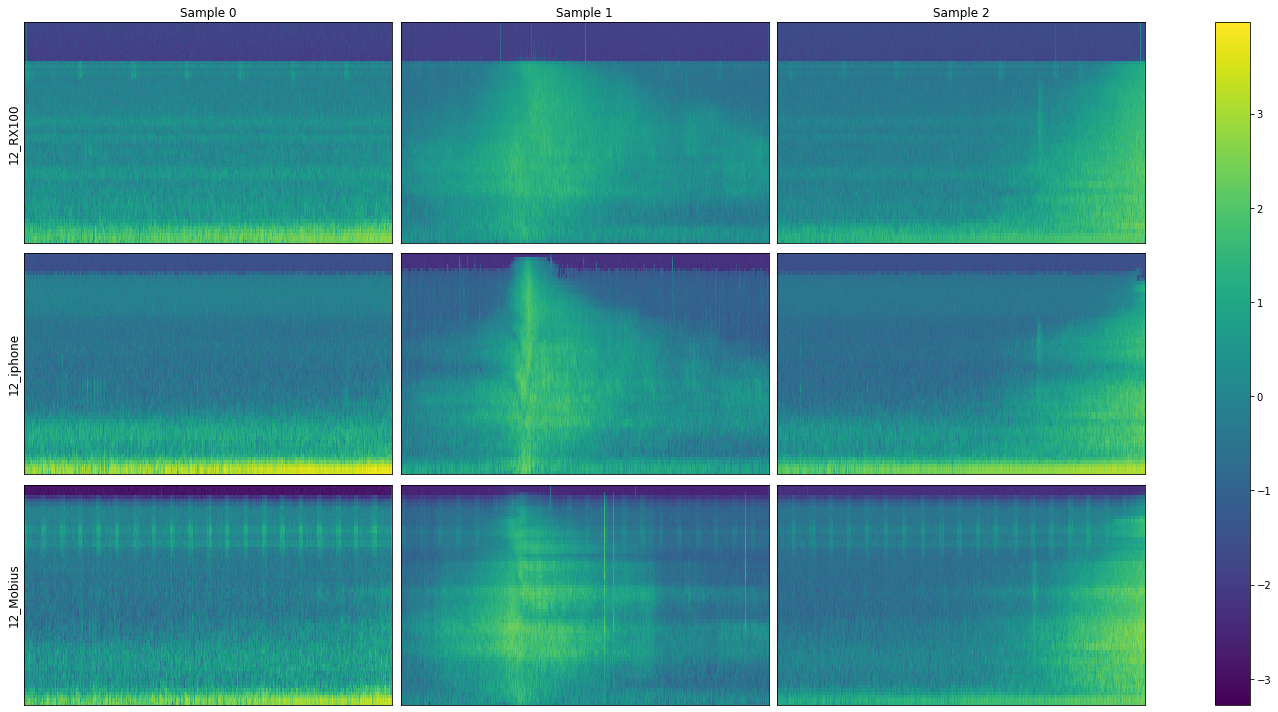

In [ ]:
n_domains = 3
n_samples = 3

s1, sr1 = torch.load('data/audio_tensors/12_RX100.MP4.pt')
s2, sr2 = torch.load('data/audio_tensors/12_iphone.MP4.pt')
s3, sr3 = torch.load('data/audio_tensors/12_Mobius.MP4.pt')

vmin = np.inf
vmax = -np.inf

features = defaultdict(list)

for i in range(n_samples):
    f_i = int(np.random.choice(len(s1)))
    f_j = int(f_i + 20 * sr1)
    
    for s in [s1, s2, s3]:
        X = s[f_i: f_j]
        X = transformation(X).squeeze()
        vmin = min(X.min(), vmin)
        vmax = max(X.max(), vmax)
        features[i].append(X)

fig, axes = plt.subplots(n_samples, n_domains, figsize=(20, 10))

for i in range(n_samples):
    for j in range(n_domains):
        ax = axes[i, j]
        im = ax.pcolormesh(features[j][i], vmin=vmin, vmax=vmax)
        
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

cols = [f'Sample {i}' for i in range(n_samples)]
rows = ['12_RX100', '12_iphone', '12_Mobius']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, size='large')
    
plt.tight_layout()
fig.colorbar(im, ax=axes.tolist());